# Tutorial 2 1D Particle Filter
In this tutorial, we will try to estimate an unknown target position using a single robot equipped with a range sensor. The measurement of the sensor has some gaussian noise Normal($\mu$ = 0, $\sigma^2$ = 1). The robot can only move in x-axis and it will keep updating the distance between the robot and the target position.

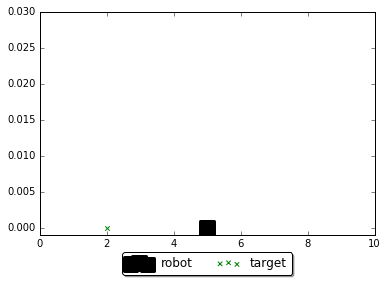

In [1]:
import matplotlib.pyplot as plt
robot_position = [5,6,7,8,9]
target_position = 2
p1 = plt.scatter(robot_position[0], 0, marker='s',color='k', s=180,lw=3)
p2 = plt.scatter(target_position, 0, marker='x', color='g')
plt.xlim((0,10))
plt.ylim((-0.001, 0.03))
plt.legend([p1, p2], ['robot', 'target'], loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In the very first step of the particle filter, you will need 'particles' which contains hypothesis state of the target. In this case, we only need the position in x-axis and distance measure.

In create_uniform_particles function below, we create an empty array with size Nx2. Now we only use uniform random for the position. We will calculate the distance of the particles later.

In [2]:
from numpy.random import uniform
import numpy as np
def create_uniform_particles(x_range, N):
    particles = np.empty((N, 2))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    return particles

Next, we need to update the weight of the particle filter using the distance measured from the robot to the target position (z) compare with the distance measure from the robot to the particles (particles[:, 1]). In addition, we need variable R as the sensor_std_err.  scipy.stats.norm is a normal continuous random variable. In the end, the weights are normalized. 

In [4]:
import scipy.stats
def update(particles, weights, z, R):
    N = len(particles)
    weights *= scipy.stats.norm(particles[:, 1], R).pdf(z)
    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize, final weight will be "1"

In this example, we have 2 estimation methods: weight average (mean) and highest weight (best).

In [5]:
import operator
def estimate(particles, weights):
    pos = particles[:, 0]
    mean = np.average(pos, weights=weights, axis=0)
    index, value = max(enumerate(weights), key=operator.itemgetter(1))
    best = particles[index, 0]
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var, best

After the weights update, we need to do the resample to get rid of the low weight particles and respawn them somewhere else (which should be more useful). In this case, we do multinomial resampling which resamples particles according to their weights (higher weights = higher chance to get resampled). 

In [6]:
def resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, np.random.rand(N))
    
    particles[:] = particles[indexes]
    weights[:] = weights[indexes]

In this function, we will call all particle filter steps. The for-loop will update the position of the robot, update the range sensor measurement, calculate particles measurement, calculate weights, do the resample, and get the estimation.

In [7]:
import matplotlib.pyplot as plt
def run_pf(N, iters, sensor_std_err, xlim):
    plt.figure()
    # initialize weights and particles
    weights = np.zeros(N)
    weights.fill(1.0 / N)
    particles = create_uniform_particles(xlim, N)

    for i in range(iters):
        # update the range sensor measurement with some error
        z = abs(robot_position[i] - target_position + np.random.normal(0, 1))
        # update the particles measurement
        particles[:, 1] = abs(particles[:, 0]-robot_position[i])
        # calculate and update weights
        update(particles, weights, z, sensor_std_err)
        # estimation
        mean, var, best = estimate(particles, weights)
        # do resample
        resample(particles, weights)
        
        # print and plot
        print('Iteration ' + str(i+1))
        print('Mean estimate = ' + str(mean))
        print('Best estimate = ' + str(best))
        print('==========================================')
        plt.scatter(particles[:, 0], weights, color='k', marker=',', s=1)
        p1 = plt.scatter(robot_position[i], 0, marker='s',color='k', s=180,lw=3)
        p2 = plt.scatter(target_position, 0, marker='x', color='g')
        p3 = plt.scatter(mean, 0, marker='o', color='r')
        p4 = plt.scatter(best, 0, marker='p', color='b')
        plt.xlim(*xlim)
        plt.ylim((-0.001, max(weights)))
        plt.legend([p1, p2, p3, p4], ['robot', 'target', 'mean estimate', 'best estimate'], loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
        plt.show()

    print('- Summary -')
    print('Mean estimate = ' + str(mean))
    print('Best estimate = ' + str(best))
    print('Target position = ' + str(target_position))
    print('Mean estimate error = ' + str(abs(mean-target_position)))
    print('Best estimate error = ' + str(abs(best-target_position)))


In the main program, we need to define the number of the particle (N). The number of iterations is coresponding to the number of robot positions. The target position is fixed at x = 2. The sensor_std_err is set to 1. The size of workspace (xlim) is limited to (0,10).

Iteration 1
Mean estimate = 5.1665055380496785
Best estimate = 7.091225647019707


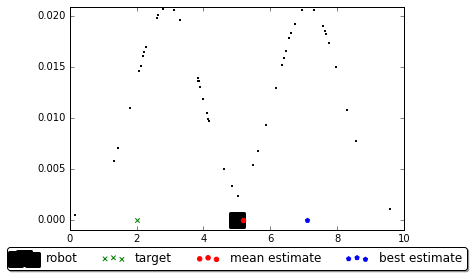

Iteration 2
Mean estimate = 2.858056969637945
Best estimate = 2.247349117973699


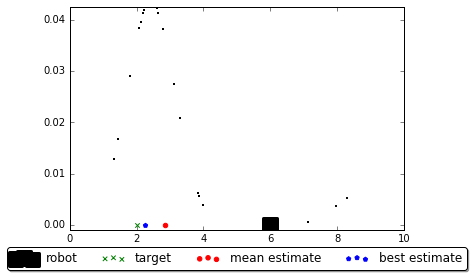

Iteration 3
Mean estimate = 2.219260190978893
Best estimate = 2.0475093579786243


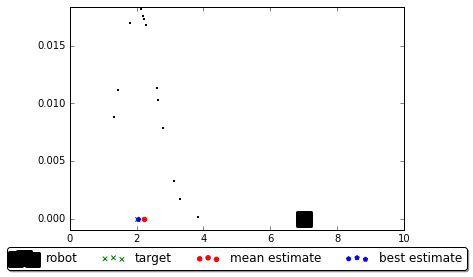

Iteration 4
Mean estimate = 2.1651681870238075
Best estimate = 2.0475093579786243


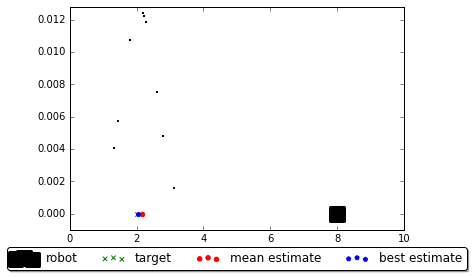

Iteration 5
Mean estimate = 2.1765221340515883
Best estimate = 2.247349117973699


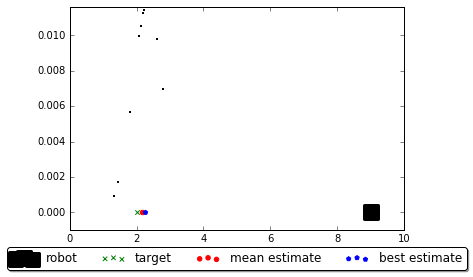

- Summary -
Mean estimate = 2.1765221340515883
Best estimate = 2.247349117973699
Target position = 2
Mean estimate error = 0.17652213405158834
Best estimate error = 0.24734911797369907


In [8]:
## main program
robot_position = [5,6,7,8,9]
target_position = 2
N = 100
sensor_std_err = 1
xlim = (0, 10)
run_pf(N, iters = len(robot_position), sensor_std_err = sensor_std_err, xlim = xlim)